*italicized text*# Exploratory Analysis
[link text](https://)

# Explore

In [ ]:
#import libraries and view dataset
import numpy as np
import pandas as pd
from pandas import Series
from numpy.random import randn
import csv #csv library col-name
import scipy as sp
import matplotlib.pyplot as plt

#import data from google drive
from google.colab import drive
drive.mount('/content/drive')

# read charge, discharge, and impedance data for B0005 and create pandas dataframes for each
battery_data = pd.read_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Analyze the dataset
print(battery_data.head())  # Print the first few rows to understand the data structure

# Focus on specific attributes
attributes_of_interest = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'ambient_temperature', 'Time']

# Basic summary statistics
print(battery_data.describe())

   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.873017         -0.001201             24.655358           0.000   
1          3.479394         -4.030268             24.666480          -4.036   
2          4.000588          1.512731             24.675394           1.500   
3          4.012395          1.509063             24.693865           1.500   
4          4.019708          1.511318             24.705069           1.500   

   Voltage_charge    Time cycle_type  \
0           0.003   0.000     charge   
1           1.570   2.532     charge   
2           4.726   5.500     charge   
3           4.742   8.344     charge   
4           4.753  11.125     charge   

                                          start_time  ambient_temperature  \
0  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
1  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
2  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8... 

In [ ]:
# Fix the time offset such that each cycle begins when the previous one ends
# Detect when a new cycle starts (time resets to zero or a lower value than the end of the previous cycle)
battery_data['new_cycle'] = battery_data['Time'].diff() < 0

# Initiate a cumulative time shift that starts with zero
battery_data['time_shift'] = 0

# Loop through the data and apply the time shift for each new cycle
for i in range(1, len(battery_data)):
    if battery_data.loc[i, 'new_cycle']:
        battery_data.loc[i:, 'time_shift'] += battery_data.loc[i-1, 'Time']

# Apply the time shift
battery_data['Corrected_time'] = battery_data['Time'] + battery_data['time_shift']

In [ ]:
battery_data = battery_data.drop("new_cycle", axis='columns')
battery_data = battery_data.drop("time_shift", axis='columns')

print(battery_data.head())  # Print the first few rows to understand the data structure

   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.873017         -0.001201             24.655358           0.000   
1          3.479394         -4.030268             24.666480          -4.036   
2          4.000588          1.512731             24.675394           1.500   
3          4.012395          1.509063             24.693865           1.500   
4          4.019708          1.511318             24.705069           1.500   

   Voltage_charge    Time cycle_type  \
0           0.003   0.000     charge   
1           1.570   2.532     charge   
2           4.726   5.500     charge   
3           4.742   8.344     charge   
4           4.753  11.125     charge   

                                          start_time  ambient_temperature  \
0  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
1  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
2  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8... 

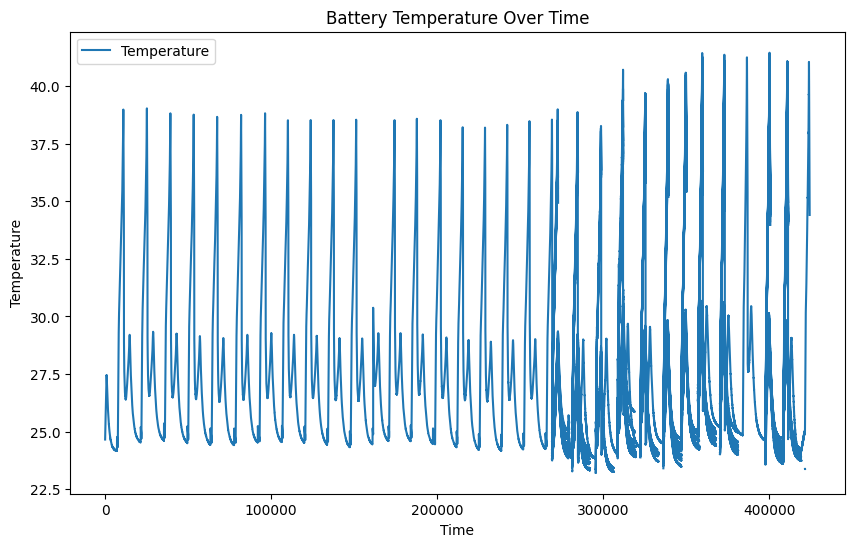

In [ ]:
# Plotting a simple static plot for initial visualization (replace 'time' with your actual time column if different)
plt.figure(figsize=(10, 6))
plt.plot(battery_data['Corrected_time'], battery_data['Temperature_measured'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Battery Temperature Over Time')
plt.legend()
plt.show()

In [ ]:
# Calculate necessary values for Heat Conduction
# Ensure 'Current_measured' is numeric
battery_data['Current_measured'] = pd.to_numeric(battery_data['Current_measured'], errors='coerce')

# Estimate initial impedance if necessary (using the average value of 200 milliohms)
estimated_initial_impedance = 0.2  # in ohms

# Assuming 'Battery_impedance' is a column with the impedance measurements
# If no impedance measurement is available, use the estimated initial impedance
battery_data['Battery_impedance'].fillna(estimated_initial_impedance, inplace=True)
battery_data['current_impedance'] = pd.to_numeric(battery_data['Battery_impedance'].ffill(), errors='coerce')

# Fill NaN values in 'Current_measured' if there are any after conversion
battery_data['Current_measured'].fillna(battery_data['Current_measured'].mean(), inplace=True)

# Calculate the change in temperature (ΔT) and the change in time (Δt)
battery_data['ΔT'] = battery_data['Temperature_measured'].diff().fillna(0)
battery_data['Δt'] = battery_data['Corrected_time'].diff().fillna(battery_data['Corrected_time'].iloc[1])

# Compute the temperature gradient over time
battery_data['temp_gradient'] = battery_data['ΔT'] / battery_data['Δt']

# Compute the heat generated using the dynamic impedance and the measured current
battery_data['Heat_generated'] = battery_data['Current_measured'] ** 2 * battery_data['current_impedance'] * battery_data['Δt']

# For an 18650 cylindrical battery, the surface area can be approximated using the dimensions of the battery:
# A = 2 * pi * radius * height
A = 0.0042

# Calculate the heat flux using Fourier's Law: q = -k * ∇T
# Placeholder for thermal conductivity 'k'
k = 0.43 # W/mK, placeholder value for thermal conductivity
battery_data['heat_flux'] = -k * battery_data['temp_gradient']

# we can calculate the overall heat loss rate (power) assuming the battery's surface is the area of heat dissipation.
# This will be an approximation, assuming that the entire battery surface is at the temperature measured by the sensor.
battery_data['heat_loss_rate'] = -k * battery_data['temp_gradient'] * A

# Display the new computed features
print(battery_data[['Corrected_time', 'Temperature_measured', 'ΔT', 'Δt', 'temp_gradient', 'current_impedance', 'Heat_generated', 'heat_flux', 'heat_loss_rate']].head())

   Corrected_time  Temperature_measured        ΔT     Δt  temp_gradient  \
0           0.000             24.655358  0.000000  2.532       0.000000   
1           2.532             24.666480  0.011122  2.532       0.004393   
2           5.500             24.675394  0.008915  2.968       0.003004   
3           8.344             24.693865  0.018471  2.844       0.006495   
4          11.125             24.705069  0.011204  2.781       0.004029   

   current_impedance  Heat_generated  heat_flux  heat_loss_rate  
0                0.2    7.300192e-07  -0.000000       -0.000000  
1                0.2    8.225488e+00  -0.001889       -0.000008  
2                0.2    1.358367e+00  -0.001292       -0.000005  
3                0.2    1.295312e+00  -0.002793       -0.000012  
4                0.2    1.270407e+00  -0.001732       -0.000007  


In [ ]:
# Calculate the heat transfer rate due to convection

# Constants for air at room temperature
g = 9.81  # m/s^2, acceleration due to gravity
nu_air = 15.89e-6  # m^2/s, kinematic viscosity of air
alpha_air = 22.5e-6  # m^2/s, thermal diffusivity of air
k_air = 0.0257  # W/(m·K), thermal conductivity of air
T_ambient_kelvin = 273.15 + battery_data['ambient_temperature']  # Convert to Kelvin for beta calculation

# Empirical constants for Nusselt number correlation, assuming laminar flow over a vertical plate
C = 0.59  # Empirical constant, varies depending on the situation - Natural Flow
n = 0.25  # Empirical constant for laminar flow

# Characteristic length for Grashof number, using battery height
L = 0.065  # m, height of a standard 18650 battery

# Calculate Grashof and Prandtl numbers
Gr = (g * (1/T_ambient_kelvin) * (battery_data['Temperature_measured'] - battery_data['ambient_temperature']) * L**3) / nu_air**2
Pr = nu_air / alpha_air

# Calculate Nusselt number
Nu = C * (Gr * Pr)**n

# Calculate convective heat transfer coefficient 'h' using Nusselt number
h = (Nu * k_air) / L

# Calculate convective heat transfer rate
battery_data['convective_heat_transfer'] = h * (battery_data['Temperature_measured'] - battery_data['ambient_temperature']) * A

# Display the new computed heat transfer rate due to convection
print(battery_data[['Corrected_time', 'Temperature_measured', 'ambient_temperature', 'convective_heat_transfer']].head())
battery_data.to_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data_fixed.csv', index=False)

   Corrected_time  Temperature_measured  ambient_temperature  \
0           0.000             24.655358                   24   
1           2.532             24.666480                   24   
2           5.500             24.675394                   24   
3           8.344             24.693865                   24   
4          11.125             24.705069                   24   

   convective_heat_transfer  
0                  0.007290  
1                  0.007445  
2                  0.007570  
3                  0.007830  
4                  0.007988  


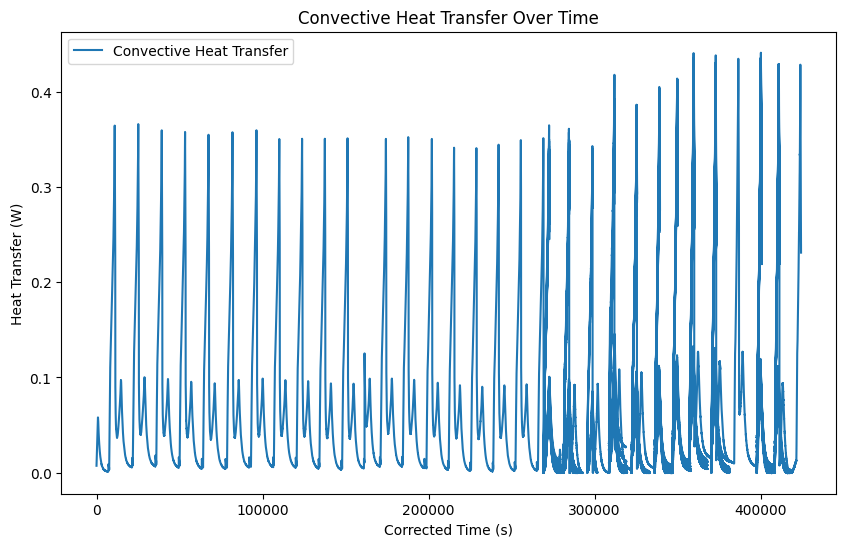

In [ ]:
# Plot the convective heat transfer over time
plt.figure(figsize=(10, 6))
plt.plot(battery_data['Corrected_time'], battery_data['convective_heat_transfer'], label='Convective Heat Transfer')
plt.xlabel('Corrected Time (s)')
plt.ylabel('Heat Transfer (W)')
plt.title('Convective Heat Transfer Over Time')
plt.legend()
plt.show()

In [ ]:
import pygame
import numpy as np
import pandas as pd
import time

# Initialize Pygame
pygame.init()

#import data from google drive
from google.colab import drive
drive.mount('/content/drive')
battery_data = pd.read_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data_fixed.csv')

# Original Battery dimensions
original_radius = 18  # in mm
original_height = 65  # in mm
original_circumference = int(2 * np.pi * original_radius)

# Scale down the grid dimensions to 75%
scale_factor = 0.75
grid_width, grid_height = int(original_circumference * scale_factor), int(original_height * scale_factor)
cell_size = 5  # Size of each cell in pixels, adjust as needed

# Calculate window size to be larger than the grid
window_width = original_circumference * cell_size
window_height = original_height * cell_size
window = pygame.display.set_mode((window_width, window_height))

# Initialize simulation parameters
initial_temperature = 24  # Starting temperature, in degrees Celsius
current_temperature = initial_temperature

# from the battery dataset
def simulate_temperature_change(time_data, heat_generated, heat_flux, heat_loss_rate, convective_heat_transfer, initial_temperature):
    specific_heat_capacity = 900  # J/(kg*K) for lithium-ion battery
    battery_mass = 0.045  # kg for a typical 18650 battery

    # Initialize variables
    temperature = initial_temperature
    temperatures = [initial_temperature]  # List to store temperature at each time step

    # Iterate over each time step
    for i in range(1, len(time_data)):
        # Calculate time interval
        delta_t = time_data[i] - time_data[i-1]

        # Heat accumulation
        heat_in = heat_generated[i] * delta_t  # Assuming heat_generated is power in watts

        # Heat dissipation
        heat_out = (heat_flux[i] + heat_loss_rate[i] + convective_heat_transfer[i]) * delta_t

        # Net heat change
        net_heat = heat_in - heat_out

        # Temperature change
        delta_temp = net_heat / (specific_heat_capacity * battery_mass)
        temperature += delta_temp

        # Append new temperature to the list
        temperatures.append(temperature)

    return temperatures

# This function would be called with your actual data lists and an initial temperature:
temperatures_over_time = simulate_temperature_change(
    time_data=battery_data['Δt'].tolist(),
    heat_generated=battery_data['Heat_generated'].tolist(),
    heat_flux=battery_data['heat_flux'].tolist(),
    heat_loss_rate=battery_data['heat_loss_rate'].tolist(),
    convective_heat_transfer=battery_data['convective_heat_transfer'].tolist(),
    initial_temperature=initial_temperature
)

# Determine min and max temperature for color mapping
min_temp = np.percentile(temperatures_over_time, 5)
max_temp = np.percentile(temperatures_over_time, 95)

# Function to map temperature to color
def temperature_to_color(temp_change, min_temp, max_temp):
    # Adjust the range to increase color sensitivity
    range_center = (min_temp + max_temp) / 2
    adjusted_range = max(max_temp - range_center, range_center - min_temp)

    # Ensure adjusted_range is not zero to avoid division by zero
    if adjusted_range == 0:
        adjusted_range = 1  # Prevent division by zero

    # Normalize temperature change between 0 and 1 with increased sensitivity
    normalized_temp = (temp_change - range_center) / adjusted_range
    normalized_temp = min(max(normalized_temp, -1), 1)  # Clamp between -1 and 1

    # Handle NaN case for normalized_temp
    if np.isnan(normalized_temp):
        normalized_temp = 0  # Default value or choose an appropriate action

    # Convert to color (blue to red)
    blue = max(0, min(255, int(255 * (1 - normalized_temp))))
    red = max(0, min(255, int(255 * (1 + normalized_temp))))

    return (red, 0, blue)

# Initialize a 2D grid for temperature distribution
temperature_grid = np.zeros((grid_width, grid_height))

# Function to update the temperature grid
def update_temperature_grid(grid, current_temperature, previous_temperature):
    # Calculate the normalized temperature change
    normalized_temp_change = (current_temperature - previous_temperature) / max(abs(previous_temperature), 1e-5)
    normalized_temp_change = max(min(normalized_temp_change, 1), -1)  # Clamp between -1 and 1

    center_x, center_y = grid.shape[0] // 2, grid.shape[1] // 2

    # Determine heating or cooling based on the temperature change
    is_heating = current_temperature > previous_temperature

    if is_heating:
        # Heating: Spread heat from the center
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                # Calculate distance from the center
                distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)

                # The closer to the center, the more the temperature increases
                grid[x, y] = min(grid[x, y] + normalized_temp_change * max(0, 1 - distance / center_x), 1)
    else:
        # Cooling: Decrease temperature from the edges inward
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                # Calculate distance from the nearest edge
                distance_to_edge = min(x, grid.shape[0] - x - 1, y, grid.shape[1] - y - 1)

                # The closer to the edge, the more the temperature decreases
                grid[x, y] = max(grid[x, y] - normalized_temp_change * max(0, 1 - distance_to_edge / center_x), 0)

    return grid

# Function for drawing text on the simulation
def draw_text(surface, text, position, font_size=24, color=(255, 255, 255)):
    font = pygame.font.Font(None, font_size)
    text_surface = font.render(text, True, color)
    surface.blit(text_surface, position)

# Start the simulation at the first data point
current_time_index = 0
previous_time = 0

print("Min temp:", min_temp, "Max temp:", max_temp)

# Main simulation loop
change_time = battery_data['Δt'].tolist()
previous_temperature = initial_temperature
scaling_factor = 5
start_time = time.time()
running = True
current_time_index = 0

while running:
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Get the time step from the data
    time_step = change_time[current_time_index] / scaling_factor

    # If enough time has passed for the next time step
    if elapsed_time >= time_step:
        # Reset the start time for the next time step
        start_time = time.time()

        # Calculate the new temperature
        current_temperature = temperatures_over_time[current_time_index]

        print("Current temperature:", current_temperature)

        # Update the temperature grid
        temperature_grid = update_temperature_grid(temperature_grid, current_temperature, previous_temperature)

        # Draw the grid
        for x in range(grid_width):
            for y in range(grid_height):
                temp = temperature_grid[x, y]
                color = temperature_to_color(temp, min_temp, max_temp)
                print(color)
                pygame.draw.rect(window, color, (x * cell_size, y * cell_size, cell_size, cell_size))

        previous_temperature = current_temperature

        # Display current time and temperature
        temperature_info = f"Time: {time_step:.2f}, Temperature: {current_temperature}"

        # Calculate position for the text (centered horizontally, at the bottom)
        text_x = window_width // 2
        text_y = window_height - 30  # 30 pixels from the bottom, adjust as needed
        draw_text(window, temperature_info, (text_x, text_y))

        # Update the display
        pygame.display.flip()

        # Increment the time index
        current_time_index += 1
        if current_time_index >= len(battery_data['Δt']):
            running = False  # End the simulation if we've gone through all data

    # Pygame event handling
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_UP:
                scaling_factor *= 1.1  # Increase speed
            elif event.key == pygame.K_DOWN:
                scaling_factor /= 1.1  # Decrease speed
                scaling_factor = max(scaling_factor, 0.1)  # Prevent scaling factor from going below 0.1
            elif event.key == pygame.K_p:  # Press 'P' to pause/unpause
                paused = not paused
            elif event.key == pygame.K_s:  # Press 'S' to take a screenshot
                pygame.image.save(window, f'screenshot_{time.time()}.png')

# Shutdown Pygame
pygame.quit()

Streaming output truncated to the last 5000 lines.
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 255)
(255, 0, 25

KeyboardInterrupt: ignored

In [ ]:
import pygame
import numpy as np
import pandas as pd
import time

# Initialize Pygame
pygame.init()

#import data from google drive
from google.colab import drive
drive.mount('/content/drive')
battery_data = pd.read_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data_fixed.csv')

# Original Battery dimensions
original_radius = 18  # in mm
original_height = 65  # in mm
original_circumference = int(2 * np.pi * original_radius)

# Scale down the grid dimensions to 75%
scale_factor = 0.75
grid_width, grid_height = int(original_circumference * scale_factor), int(original_height * scale_factor)
cell_size = 5  # Size of each cell in pixels, adjust as needed

# Calculate window size to be larger than the grid
window_width = original_circumference * cell_size
window_height = original_height * cell_size
window = pygame.display.set_mode((window_width, window_height))

# Initialize simulation parameters
initial_temperature = 24  # Starting temperature, in degrees Celsius
current_temperature = initial_temperature

# Assuming actual_temperature_data is a list of actual temperature readings
actual_temperature_data = battery_data['Temperature_measured'].tolist()

# Determine min and max temperature for color mapping
min_temp = min(actual_temperature_data)
max_temp = max(actual_temperature_data)

# Function to map temperature to color
def temperature_to_color(temp):
    # Map the temperature value to a color
    # For simplicity, let's assume temp is a value between 0 (cool) and 1 (hot)
    blue = max(0, int(255 * (1 - temp)))
    red = max(0, int(255 * temp))
    return (red, 0, blue)

# Initialize a 2D grid for temperature distribution
temperature_grid = np.zeros((grid_width, grid_height))

# Function to update the temperature grid
def update_temperature_grid(grid, current_temperature, previous_temperature):
    # Determine whether we are in the heating or cooling phase
    is_heating = current_temperature > previous_temperature

    # Heating or Cooling Logic
    if is_heating:
        # Logic for spreading heat
        # For simplicity, increasing temperature in the center
        center_x, center_y = grid.shape[0] // 2, grid.shape[1] // 2
        radius = 5  # Radius of the heating area
        for x in range(center_x - radius, center_x + radius):
            for y in range(center_y - radius, center_y + radius):
                grid[x % grid.shape[0], y % grid.shape[1]] = min(grid[x, y] + 0.01, 1)  # Max at 1
    else:
        # Logic for cooling
        # Gradually decrease the temperature from the edges inward
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                distance_to_edge = min(x, grid.shape[0] - x, y, grid.shape[1] - y)
                grid[x, y] = max(grid[x, y] - 0.01, 0)  # Min at 0

    return grid

# Function for drawing text on the simulation
def draw_text(surface, text, position, font_size=24, color=(255, 255, 255)):
    font = pygame.font.Font(None, font_size)
    text_surface = font.render(text, True, color)
    surface.blit(text_surface, position)

# Main simulation loop
time_data = battery_data['Δt'].tolist()
current_temp = battery_data['Temperature_measured'].tolist()
previous_temp = initial_temperature
current_time_index = 0
running = True
scaling_factor = 1

while running:
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Get the time step from the data
    time_step = time_data[current_time_index] / scaling_factor

    # Get the current temperature from the data
    current_temp_now = current_temp[current_time_index]

    # If enough time has passed for the next time step
    if elapsed_time >= time_step:
        # Reset the start time for the next time step
        start_time = time.time()

    # Update the temperature grid
    temperature_grid = update_temperature_grid(temperature_grid, current_temp_now, previous_temp)

    # Draw the grid
    for x in range(grid_width):
        for y in range(grid_height):
            temp = temperature_grid[x, y]
            color = temperature_to_color(temp)
            print(color)
            pygame.draw.rect(window, color, (x * cell_size, y * cell_size, cell_size, cell_size))

    # Display current time and temperature
    temperature_info = f"Time: {time_step:.2f}, Temperature: {current_temp_now}"
    previous_temp = current_temp_now

    # Calculate position for the text (centered horizontally, at the bottom)
    text_x = window_width // 2
    text_y = window_height - 30  # 30 pixels from the bottom, adjust as needed
    draw_text(window, temperature_info, (text_x, text_y))

    # Update the display
    pygame.display.flip()

    # Increment the time index and loop termination condition
    current_time_index += 1
    if current_time_index >= len(battery_data['Δt'].tolist()):
        running = False  # End the simulation if we've gone through all data

    # Pygame event handling
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_UP:
                scaling_factor *= 1.1  # Increase speed
            elif event.key == pygame.K_DOWN:
                scaling_factor /= 1.1  # Decrease speed
                scaling_factor = max(scaling_factor, 0.1)  # Prevent scaling factor from going below 0.1
            elif event.key == pygame.K_p:  # Press 'P' to pause/unpause
                paused = not paused
            elif event.key == pygame.K_s:  # Press 'S' to take a screenshot
                pygame.image.save(window, f'screenshot_{time.time()}.png')

# Shutdown Pygame
pygame.quit()

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


MessageError: ignored

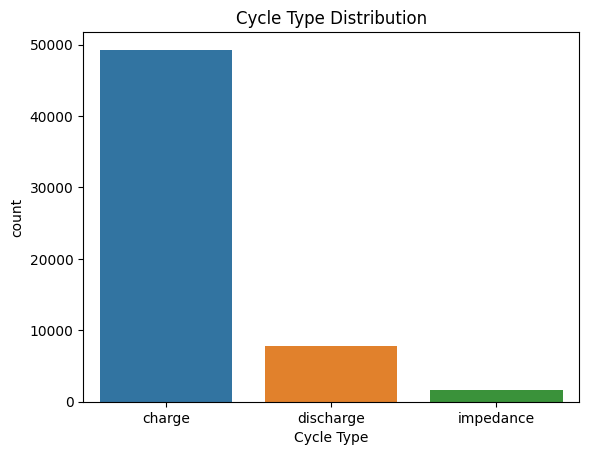

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
#Plot current ratio versus corrected time (lineplot)

NASA_clean = pd.read_csv('/content/AllData_FixedSub.csv')

#How does ratio of sense current to battery current change over time?
ax = sns.countplot(data=NASA_clean, x='cycle_type').set(xlabel='Cycle Type',title='Cycle Type Distribution')
plt.pyplot.savefig('CycleTypeDistribution.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

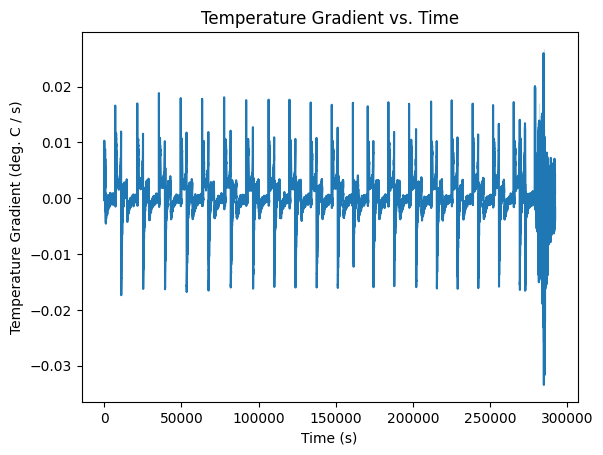

In [ ]:
#Plot temperature gradient versus corrected time (lineplot)

ax = sns.lineplot(data=NASA_clean, x='Corrected_time',y='temp_gradient').set(xlabel='Time (s)',ylabel='Temperature Gradient (deg. C / s)',title='Temperature Gradient vs. Time')
plt.pyplot.savefig('TemperatureGradientVsTime.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

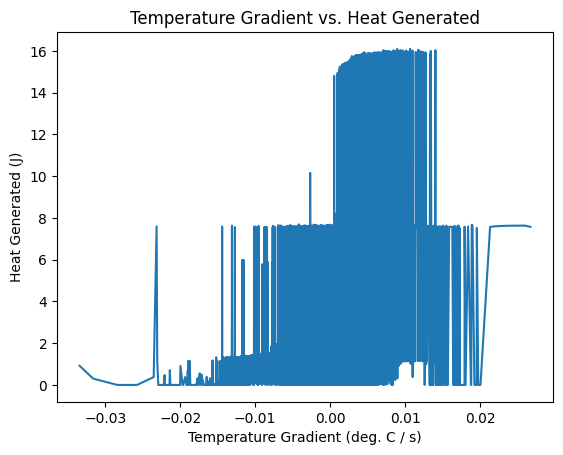

In [ ]:
#Plot heat generated versus temperature gradient (lineplot)

ax = sns.lineplot(data=NASA_clean, x='temp_gradient',y='Heat_generated').set(xlabel='Temperature Gradient (deg. C / s)',ylabel='Heat Generated (J)',title='Temperature Gradient vs. Heat Generated')
plt.pyplot.savefig('TemperatureGradientVsHeatGenerated.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

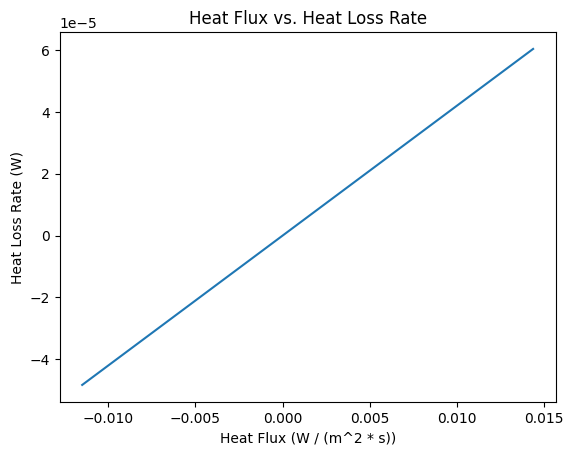

In [ ]:
#Plot heat flux vs. heat loss rate (lineplot)

ax = sns.lineplot(data=NASA_clean, x='heat_flux',y='heat_loss_rate').set(xlabel='Heat Flux (W / (m^2 * s))',ylabel='Heat Loss Rate (W)',title='Heat Flux vs. Heat Loss Rate')
plt.pyplot.savefig('HeatFluxVsHeatLossRate.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

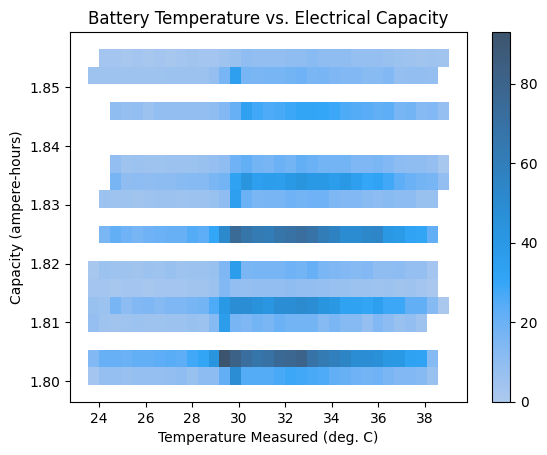

In [ ]:
#Plot heat flux vs. heat loss rate (lineplot)

ax = sns.histplot(data=NASA_clean, x='Temperature_measured',y='Capacity',cbar=True).set(xlabel='Temperature Measured (deg. C)',ylabel='Capacity (ampere-hours)',title='Battery Temperature vs. Electrical Capacity')
plt.pyplot.savefig('TempVsCapacity.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

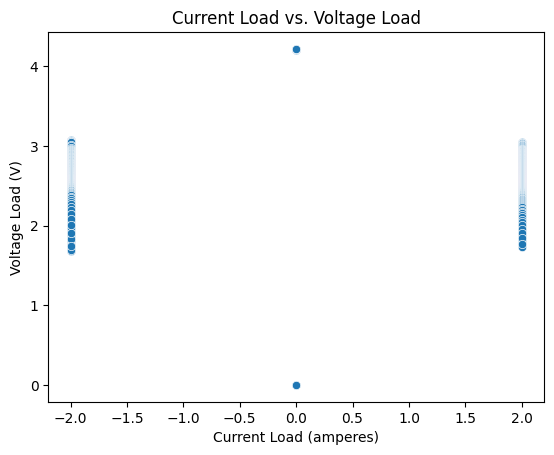

In [ ]:
#Plot current load vs. ratio (scatterplot)

ax = sns.scatterplot(data=NASA_clean, x='Current_load',y='Voltage_load').set(xlabel='Current Load (amperes)',ylabel='Voltage Load (V)',title='Current Load vs. Voltage Load')
plt.pyplot.savefig('CurrentLoadVsVL.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

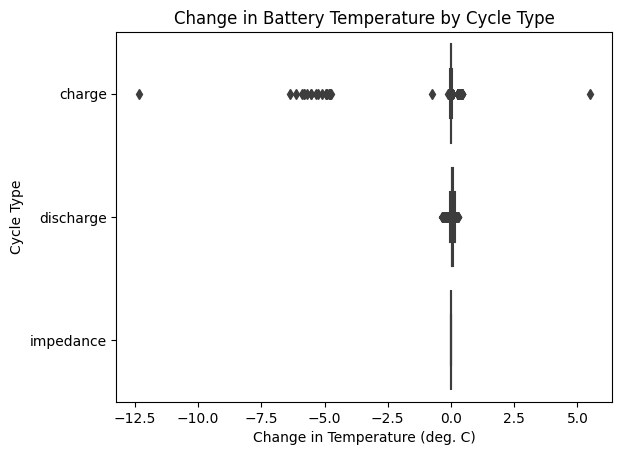

In [ ]:
#Plot change in temperature by battery class (boxplot)

ax = sns.boxplot(data=NASA_clean, x='ΔT',y='cycle_type').set(xlabel='Change in Temperature (deg. C)',ylabel='Cycle Type',title='Change in Battery Temperature by Cycle Type')
plt.pyplot.savefig('DeltaTempClass.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

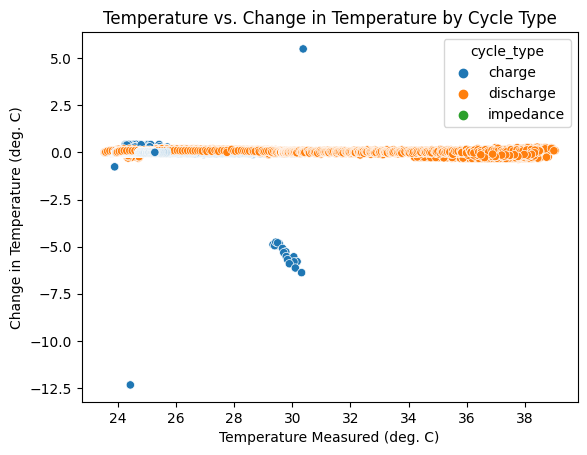

In [ ]:
#Plot change in temperature by total temperature by battery class (scatterplot)

ax = sns.scatterplot(data=NASA_clean, x='Temperature_measured',y='ΔT', hue='cycle_type').set(xlabel='Temperature Measured (deg. C)',ylabel='Change in Temperature (deg. C)',title='Temperature vs. Change in Temperature by Cycle Type')
plt.pyplot.savefig('DeltaTempTotTempClass.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

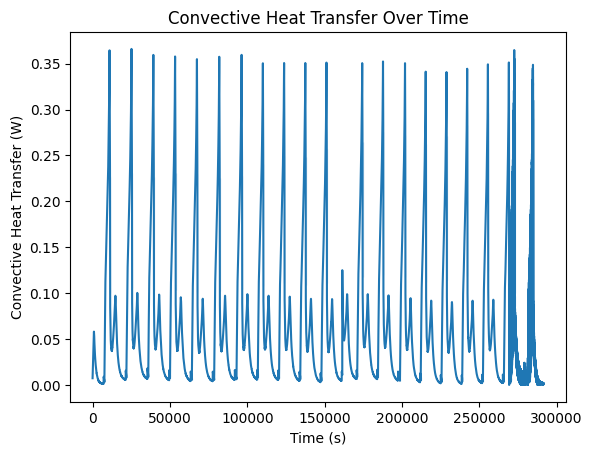

In [ ]:
#Plot convective heat tranfer over time (lineplot)

ax = sns.lineplot(data=NASA_clean, x='Corrected_time',y='convective_heat_transfer').set(xlabel='Time (s)',ylabel='Convective Heat Transfer (W)',title='Convective Heat Transfer Over Time')
plt.pyplot.savefig('CHTVsTime.png',bbox_inches='tight', dpi=600, facecolor='white',transparent=True)

# Model

# Simulation